In [1]:
from pandas import read_csv
import matplotlib.pyplot as plt #General Plotting
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix


In [2]:
# fixed acidity;"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"
winedata = read_csv('winequality-white.csv', sep = ';')
print
labels = np.array(winedata[winedata.columns[-1]]) # take provided labels from last column of dataset

valid_classes = np.array([3, 4, 5, 6, 7, 8, 9]) # only 
print("Valid Classes: ", valid_classes)

X = np.array([np.array(winedata[winedata.columns[i]]) for i in valid_classes]).T
print(X.shape)
N = len(labels)
print("Num samples: ", N)

valid_classes = np.array([0,1,2,3,4,5,6]) # only 


N_cl = np.array([X[labels == i].shape[0] for i in valid_classes])
print("Num Class Labels: ", N_cl)

priors = np.array(N_cl/N)
print("Priors: ", priors)

C = len(priors)

# First derive sample-based estimates of mean vector and covariance matrix:
#mu_hat = np.mean(X, axis=0)
mu_hat = np.array([np.mean(X[labels == i], axis = 0) for i in valid_classes]) # No labelled samples for 0, 1, 2, 10!

# Small regularization term
# reg = []
# print(ww.shape)
# for i in valid_classes:
#     w,_ = np.linalg.eig(np.cov(X[labels==i].T))
#     reg.append(np.mean(w))

# reg = np.array(reg)
# print(reg.shape)




# w,_ = np.mean(np.array([np.linalg.eig(np.cov(X[labels==i].T)) for i in valid_classes]))
# reg = np.mean(w)
# print(w.size)
reg = 0.1*np.identity(7) #7x11

Sigma_hat = np.array([np.cov(X[labels == i].T) + reg for i in valid_classes]) #7x11x11



      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.0              0.27         0.36            20.7      0.045   
1               6.3              0.30         0.34             1.6      0.049   
2               8.1              0.28         0.40             6.9      0.050   
3               7.2              0.23         0.32             8.5      0.058   
4               7.2              0.23         0.32             8.5      0.058   
...             ...               ...          ...             ...        ...   
4893            6.2              0.21         0.29             1.6      0.039   
4894            6.6              0.32         0.36             8.0      0.047   
4895            6.5              0.24         0.19             1.2      0.041   
4896            5.5              0.29         0.30             1.1      0.022   
4897            6.0              0.21         0.38             0.8      0.020   

      free sulfur dioxide  

c:\Users\meuli\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\meuli\anaconda3\lib\site-packages\numpy\core\_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
c:\Users\meuli\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\meuli\AppData\Local\Temp\ipykernel_27488\315212282.py:47: RuntimeWarning: Degrees of freedom <= 0 for slice
  Sigma_hat = np.array([np.cov(X[labels == i].T) + reg for i in valid_classes]) #7x11x11
c:\Users\meuli\anaconda3\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\Users\meuli\anaconda3\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [17]:
# fixed acidity;"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"
winedata = np.array(read_csv('winequality-white.csv', sep = ';'))
winedata[:,-1] = np.array([winedata[i,-1] -3 for i in range(winedata.shape[0])])
labels = winedata[:,-1] # take provided labels from last column of dataset
print(labels.shape)

valid_classes = np.array([0,1,2,3,4,5,6]) # only 
print("Valid Classes: ", valid_classes)

X = np.array(winedata[:,0:11])
print(X.shape)
N = len(labels)
print("Num samples: ", N)

N_cl = np.array([X[labels == i].shape[0] for i in valid_classes])
print("Num Class Labels: ", N_cl)

priors = np.array(N_cl/N)
print("Priors: ", priors)

C = len(priors)

mu_hat = np.array([np.mean(X[labels == i], axis = 0) for i in valid_classes]) # No labelled samples for 0, 1, 2, 10!

reg = 0.1*np.identity(11) #7x11

Sigma_hat = np.array([np.cov(X[labels == i].T) + reg for i in valid_classes]) #7x11x11



(4898,)
Valid Classes:  [0 1 2 3 4 5 6]
(4898, 11)
Num samples:  4898
Num Class Labels:  [  20  163 1457 2198  880  175    5]
Priors:  [0.0040833  0.03327889 0.29746835 0.44875459 0.17966517 0.03572887
 0.00102082]
[[ 8.1   0.27  0.41 ...  2.99  0.56 12.  ]
 [ 8.6   0.23  0.4  ...  3.14  0.53  9.7 ]
 [ 7.9   0.18  0.37 ...  3.18  0.63 10.8 ]
 ...
 [ 6.8   0.22  0.36 ...  3.04  0.54  9.2 ]
 [ 6.5   0.23  0.38 ...  3.29  0.54  9.7 ]
 [ 6.6   0.32  0.36 ...  3.15  0.46  9.6 ]]


In [4]:
# Implement minimum P(error) classification rule on all training samples
class_cond_likelihoods = np.array([multivariate_normal.pdf(X, mu_hat[c], Sigma_hat[c]) for c in range(len(valid_classes))])
priors_diag = np.diag(priors)
class_posteriors = priors_diag.dot(class_cond_likelihoods)

decisions = np.argmax(class_posteriors, axis = 0) 
decisions = np.array([i + valid_classes[0] for i in decisions]) # labels start at 3...

conf_matrix = confusion_matrix(decisions, labels)
print("Confusion Matrix:\n",conf_matrix)

errors = len(np.argwhere(decisions != labels))
print('Number of Misclassifications: ', errors, "\nError Estimate: ", errors/N)

Confusion Matrix:
 [[   7    2    5   12    2    4    0]
 [   1    3    7    6    0    0    0]
 [   5  106  929  615  102   16    0]
 [   7   50  496 1339  471   79    2]
 [   0    2   19  226  302   73    3]
 [   0    0    1    0    3    3    0]
 [   0    0    0    0    0    0    0]]
Number of Misclassifications:  2315 
Error Estimate:  0.4726418946508779


In [5]:
# Confusion matrix
conf_mat_b = np.zeros((C, C))

for i in valid_classes: # Each decision option
    for j in valid_classes: # Each class label
        ind_ij = np.argwhere((decisions==i) & (labels==j))
        conf_mat_b[i, j] = round(len(ind_ij)/N_cl[j],3) # Average over class sample count

        # True label = Marker shape; Decision = Marker Color
        marker = marker_shapes[j]
        plt.plot(X[ind_ij, 3], X[ind_ij, 10], 'g.', markersize=6)

        if i != j:
            plt.plot(X[ind_ij, 3], X[ind_ij, 10], 'r.', markersize=6)

print(conf_mat_b)

NameError: name 'marker_shapes' is not defined

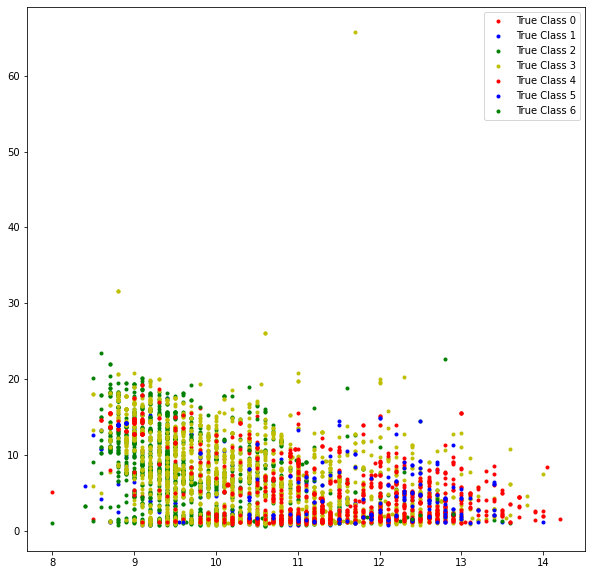

In [ ]:
# Plot for original data and their true labels
fig = plt.figure(figsize=(10, 10))
marker_shapes = '.............'
marker_colors = 'rbgyrbgyrbgy' 

for i in valid_classes:
    
    plt.plot(X[labels==i, 10], X[labels==i, 3], marker_shapes[i] + marker_colors[i], label="True Class {}".format(i))

plt.legend()

In [6]:
## PCA

# Mean-subtraction is a necessary assumption for PCA, so perform this to obtain zero-mean sample set
# C = np.array(X[labels == i] - mu_hat[i-3] for i in valid_classes)

# Get the eigenvectors (in U) and eigenvalues (in D) of the estimated covariance matrix
for j in range(len(valid_classes)):

    # Mean-subtraction is a necessary assumption for PCA, so perform this to obtain zero-mean sample set
    C = X[labels == j] - mu_hat[j]

    lambdas, U = np.linalg.eig(Sigma_hat[j])
    print(lambdas.shape)
    # Get the indices from sorting lambdas in order of increasing value, with ::-1 slicing to then reverse order
    idx = lambdas.argsort()[::-1]
    # Extract corresponding sorted eigenvectors and eigenvalues
    U = U[:, idx]
    D = np.diag(lambdas[idx])

    # Calculate the PC projections of zero-mean samples (in z)
    Z = C.dot(U)

    # Max number of PCs based on rank of X, or min(n, N)
    X_rank = np.linalg.matrix_rank(X[labels == j+3])

    rmse = np.zeros(X_rank)
    sum_eigenvals = np.zeros(X_rank)
    no_components = range(1, X_rank + 1)

    # Reconstruct the X data set from each set of projections
    for m in no_components:
        # Reconstruct based on only the 'm' components (also revert mean-centering effect)
        X_hat = Z[:, :m].dot(U[:, :m].T) + mu_hat[j]
        rmse[m-1] = np.sqrt(np.mean((X[labels == j+3] - X_hat)**2))
        sum_eigenvals[m-1] = np.sum(D[:m])
        
    # Fraction of variance explained
    fraction_var = sum_eigenvals / np.trace(Sigma_hat[j])

    # # Let's see what it looks like only along the first two PCs
    # fig = plt.figure(figsize=(10, 10))
    # plt.scatter(Z[:, 0], Z[:, 1])
    # plt.xlabel("z1")
    # plt.ylabel("z2")
    # plt.title("PCA projections to 2D space".format(valid_classes))
    # plt.show()
    # MSE should be decreasing on each iteration, 0 for the nth
    plt.figure(0)
    plt.plot(no_components, rmse)
    plt.xlabel("Dimension m of PCA")
    plt.ylabel("RMSE")

    # First eigenvalue should be significantly larger than the rest
    plt.figure(1)
    plt.plot(no_components, sum_eigenvals)
    plt.xlabel("Dimension m of PCA")
    plt.ylabel("Sum of Eigenvalues")

    # About 95% variance explined is an acceptable target 
    plt.figure(2)
    plt.plot(no_components, fraction_var)
    plt.xlabel("Dimension m of PCA")
    plt.ylabel("Fraction of Variance Explained")

(11,)


ValueError: operands could not be broadcast together with shapes (2198,11) (20,11) 

(4898, 11)
(4898, 11)


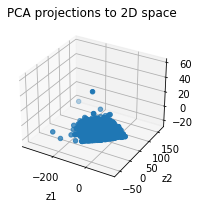

In [13]:
# First derive sample-based estimates of mean vector and covariance matrix:
mu_hat = np.mean(X, axis=0)
Sigma_hat = np.cov(X.T)

# Mean-subtraction is a necessary assumption for PCA, so perform this to obtain zero-mean sample set
C = X - mu_hat
print(C.shape)

# Get the eigenvectors (in U) and eigenvalues (in D) of the estimated covariance matrix
lambdas, U = np.linalg.eig(Sigma_hat)
# Get the indices from sorting lambdas in order of increasing value, with ::-1 slicing to then reverse order
idx = lambdas.argsort()[::-1]
# Extract corresponding sorted eigenvectors and eigenvalues
U = U[:, idx]
D = np.diag(lambdas[idx])

# Calculate the PC projections of zero-mean samples (in z)
Z = C.dot(U)
print(Z.shape)

# Let's see what it looks like only along the first two PCs
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(131, projection = '3d')
ax1.scatter(Z[:, 0], Z[:, 1], Z[:,2])
plt.xlabel("z1")
plt.ylabel("z2")
plt.title("PCA projections to 2D space")
plt.show()



In [14]:
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

# Max number of PCs based on rank of X, or min(n, N)
X_rank = np.linalg.matrix_rank(X)

rmse = np.zeros(X_rank)
sum_eigenvals = np.zeros(X_rank)
no_components = range(1, X_rank + 1)

# Reconstruct the X data set from each set of projections
for m in no_components:
    # Reconstruct based on only the 'm' components (also revert mean-centering effect)
    X_hat = Z[:, :m].dot(U[:, :m].T) + mu_hat
    rmse[m-1] = np.sqrt(np.mean((X - X_hat)**2))
    sum_eigenvals[m-1] = np.sum(D[:m])
    
# Fraction of variance explained
fraction_var = sum_eigenvals / np.trace(Sigma_hat)

Text(0, 0.5, 'Fraction of Variance Explained')

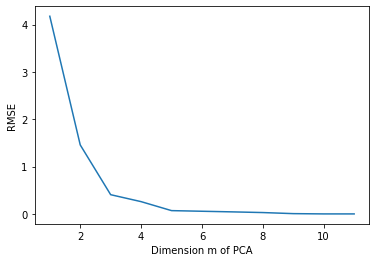

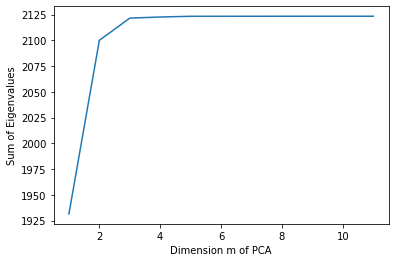

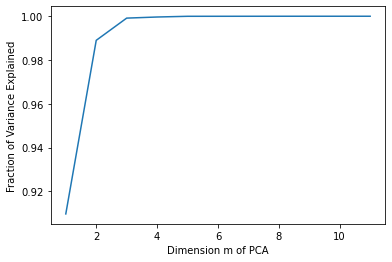

In [15]:
# MSE should be decreasing on each iteration, 0 for the nth
plt.figure(0)
plt.plot(no_components, rmse)
plt.xlabel("Dimension m of PCA")
plt.ylabel("RMSE")

# First eigenvalue should be significantly larger than the rest
plt.figure(1)
plt.plot(no_components, sum_eigenvals)
plt.xlabel("Dimension m of PCA")
plt.ylabel("Sum of Eigenvalues")

# About 95% variance explined is an acceptable target 
plt.figure(2)
plt.plot(no_components, fraction_var)
plt.xlabel("Dimension m of PCA")
plt.ylabel("Fraction of Variance Explained")